## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.regularizers import l1, l2, l1_l2
from collections import defaultdict
import matplotlib.pyplot as plt

#%matplotlib inline

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=False):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_data_shape, dropout_rate):
    model = Sequential()
    
    #卷積層1與池化層1
    model.add(Conv2D(filters=256,
                     kernel_size=(3, 3),
                     input_shape=input_data_shape,
                     activation='relu',
                     padding='same'))
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層2與池化層2
    model.add(Conv2D(filters=128,
                     kernel_size=(3, 3),
                     activation='relu',
                     padding='same'))
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#     #卷積層3與池化層3
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(Dropout(rate=0.2))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     #卷積層3與池化層4
#     model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(Dropout(rate=0.2))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #建立神經網路(平坦層、隱藏層、輸出層)
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(1e-4)))

    return model

In [6]:
## 超參數設定
OPTIMIZER = ["sgd", "rmsprop", "adam", "adagrad"]
LEARNING_RATE = 1e-4
L2_EXP = 1e-4
DROPOUT = [0.1, 0.3, 0.5]
EPOCHS = 100
BATCH_SIZE = 64
MOMENTUM = 0.95

In [7]:
tra_loss = defaultdict(list)
val_loss = defaultdict(list)
tra_accu = defaultdict(list)
val_accu = defaultdict(list)

for i, dropout in enumerate(DROPOUT):
    for j, optr in enumerate(OPTIMIZER):
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Optimizer=%s, Learning rate=%.6f, Dropout rate=%.2f" % (optr, LEARNING_RATE, dropout))
        
        # create model
        model = build_mlp(x_train.shape[1:], dropout)
        
        # optimizer
        if optr == "sgd":
            optimizer = optimizers.SGD(lr=LEARNING_RATE, decay=1e-6, momentum=MOMENTUM, nesterov=True)

        if optr == "rmsprop":
            optimizer = optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=None, decay=0.0)

        if optr == "adam":
            optimizer = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        if optr == "adagrad":
            optimizer = optimizers.Adagrad(lr=LEARNING_RATE, epsilon=None, decay=0.0)
    
        # compile model and training
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), shuffle=True)

        # Collect results
        exp_tag = "%s:%s" % (("drop_"+str(i)), str(optr))
        tra_loss[exp_tag].append(model.history.history["loss"])
        val_loss[exp_tag].append(model.history.history["val_loss"])
        
        tra_accu[exp_tag].append(model.history.history["acc"])
        val_accu[exp_tag].append(model.history.history["val_acc"])


Experiment with Optimizer=sgd, Learning rate=0.000100, Dropout rate=0.10
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 54s 1ms/step - loss: 2.3400 - acc: 0.1833 - val_loss: 2.2732 - val_acc: 0.2521
Epoch 2/100
50000/50000 [==============================] - 52s 1ms/step - loss: 2.1594 - acc: 0.2713 - val_loss: 2.0919 - val_acc: 0.3091
Epoch 3/100
50000/50000 [==============================] - 52s 1ms/step - loss: 2.0318 - acc: 0.3160 - val_loss: 2.0023 - val_acc: 0.3393
Epoch 4/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.9568 - acc: 0.3462 - val_loss: 1.9426 - val_acc: 0.3693
Epoch 5/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.8858 - acc: 0.3749 - val_loss: 1.8695 - val_acc: 0.3932
Epoch 6/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.8173 - acc: 0.3995 - val_loss: 1.8050 - val_acc: 0.4161
Epoch 7/100
50000/50000 [========================

50000/50000 [==============================] - 51s 1ms/step - loss: 0.9173 - acc: 0.7170 - val_loss: 1.0688 - val_acc: 0.6648
Epoch 60/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.9083 - acc: 0.7211 - val_loss: 1.0640 - val_acc: 0.6667
Epoch 61/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8983 - acc: 0.7243 - val_loss: 1.0562 - val_acc: 0.6730
Epoch 62/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8911 - acc: 0.7288 - val_loss: 1.0594 - val_acc: 0.6713
Epoch 63/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8832 - acc: 0.7316 - val_loss: 1.0540 - val_acc: 0.6732
Epoch 64/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8733 - acc: 0.7345 - val_loss: 1.0507 - val_acc: 0.6759
Epoch 65/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8618 - acc: 0.7374 - val_loss: 1.0421 - val_acc: 0.6782
Epoch 66/100
50000/50000 [==============

50000/50000 [==============================] - 53s 1ms/step - loss: 0.5075 - acc: 0.8565 - val_loss: 0.9356 - val_acc: 0.7194
Epoch 18/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4749 - acc: 0.8713 - val_loss: 0.8512 - val_acc: 0.7419
Epoch 19/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4450 - acc: 0.8829 - val_loss: 0.9876 - val_acc: 0.7142
Epoch 20/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4134 - acc: 0.8947 - val_loss: 0.8546 - val_acc: 0.7465
Epoch 21/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.3840 - acc: 0.9054 - val_loss: 0.8886 - val_acc: 0.7414
Epoch 22/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.3588 - acc: 0.9124 - val_loss: 0.9000 - val_acc: 0.7361
Epoch 23/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.3376 - acc: 0.9212 - val_loss: 0.9329 - val_acc: 0.7394
Epoch 24/100
50000/50000 [==============

50000/50000 [==============================] - 53s 1ms/step - loss: 0.1561 - acc: 0.9810 - val_loss: 1.2565 - val_acc: 0.7582
Epoch 77/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.1569 - acc: 0.9808 - val_loss: 1.3188 - val_acc: 0.7253
Epoch 78/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.1580 - acc: 0.9803 - val_loss: 1.3656 - val_acc: 0.7328
Epoch 79/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.1580 - acc: 0.9812 - val_loss: 1.3078 - val_acc: 0.7551
Epoch 80/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.1553 - acc: 0.9814 - val_loss: 1.5564 - val_acc: 0.7303
Epoch 81/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.1571 - acc: 0.9813 - val_loss: 1.5292 - val_acc: 0.7276
Epoch 82/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.1589 - acc: 0.9798 - val_loss: 1.3260 - val_acc: 0.7482
Epoch 83/100
50000/50000 [==============

50000/50000 [==============================] - 54s 1ms/step - loss: 0.1663 - acc: 0.9816 - val_loss: 1.0040 - val_acc: 0.7472
Epoch 35/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1667 - acc: 0.9805 - val_loss: 1.0079 - val_acc: 0.7502
Epoch 36/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1587 - acc: 0.9835 - val_loss: 1.0556 - val_acc: 0.7462
Epoch 37/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1612 - acc: 0.9819 - val_loss: 1.0216 - val_acc: 0.7502
Epoch 38/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1487 - acc: 0.9861 - val_loss: 1.0582 - val_acc: 0.7513
Epoch 39/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1500 - acc: 0.9854 - val_loss: 1.0856 - val_acc: 0.7426
Epoch 40/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1514 - acc: 0.9847 - val_loss: 1.0560 - val_acc: 0.7494
Epoch 41/100
50000/50000 [==============

50000/50000 [==============================] - 54s 1ms/step - loss: 0.0980 - acc: 0.9946 - val_loss: 1.1982 - val_acc: 0.7536
Epoch 94/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0984 - acc: 0.9937 - val_loss: 1.2261 - val_acc: 0.7512
Epoch 95/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1015 - acc: 0.9928 - val_loss: 1.2100 - val_acc: 0.7539
Epoch 96/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0958 - acc: 0.9949 - val_loss: 1.1861 - val_acc: 0.7536
Epoch 97/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0988 - acc: 0.9937 - val_loss: 1.2059 - val_acc: 0.7495
Epoch 98/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0962 - acc: 0.9944 - val_loss: 1.2143 - val_acc: 0.7558
Epoch 99/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0959 - acc: 0.9943 - val_loss: 1.1843 - val_acc: 0.7530
Epoch 100/100
50000/50000 [=============

50000/50000 [==============================] - 52s 1ms/step - loss: 1.4425 - acc: 0.5244 - val_loss: 1.4706 - val_acc: 0.5318
Epoch 52/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4396 - acc: 0.5247 - val_loss: 1.4688 - val_acc: 0.5311
Epoch 53/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4354 - acc: 0.5273 - val_loss: 1.4645 - val_acc: 0.5359
Epoch 54/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4343 - acc: 0.5272 - val_loss: 1.4621 - val_acc: 0.5368
Epoch 55/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4306 - acc: 0.5300 - val_loss: 1.4599 - val_acc: 0.5363
Epoch 56/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4294 - acc: 0.5300 - val_loss: 1.4574 - val_acc: 0.5392
Epoch 57/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4265 - acc: 0.5309 - val_loss: 1.4558 - val_acc: 0.5371
Epoch 58/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 1.6409 - acc: 0.4523 - val_loss: 1.7569 - val_acc: 0.4665
Epoch 10/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.6075 - acc: 0.4648 - val_loss: 1.7271 - val_acc: 0.4856
Epoch 11/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5786 - acc: 0.4735 - val_loss: 1.6864 - val_acc: 0.4952
Epoch 12/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5492 - acc: 0.4855 - val_loss: 1.6793 - val_acc: 0.5056
Epoch 13/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5247 - acc: 0.4942 - val_loss: 1.6592 - val_acc: 0.5089
Epoch 14/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4998 - acc: 0.5038 - val_loss: 1.6312 - val_acc: 0.5220
Epoch 15/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4790 - acc: 0.5097 - val_loss: 1.6086 - val_acc: 0.5226
Epoch 16/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 0.9244 - acc: 0.7136 - val_loss: 1.1394 - val_acc: 0.6830
Epoch 69/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.9158 - acc: 0.7152 - val_loss: 1.1242 - val_acc: 0.6925
Epoch 70/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.9103 - acc: 0.7206 - val_loss: 1.1160 - val_acc: 0.6860
Epoch 71/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.9002 - acc: 0.7210 - val_loss: 1.1142 - val_acc: 0.6813
Epoch 72/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.8971 - acc: 0.7222 - val_loss: 1.1190 - val_acc: 0.6800
Epoch 73/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.8871 - acc: 0.7255 - val_loss: 1.1161 - val_acc: 0.6881
Epoch 74/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.8850 - acc: 0.7273 - val_loss: 1.1003 - val_acc: 0.6890
Epoch 75/100
50000/50000 [==============

50000/50000 [==============================] - 53s 1ms/step - loss: 0.4850 - acc: 0.8745 - val_loss: 0.8851 - val_acc: 0.7459
Epoch 27/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4761 - acc: 0.8777 - val_loss: 0.8498 - val_acc: 0.7549
Epoch 28/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4679 - acc: 0.8814 - val_loss: 0.8752 - val_acc: 0.7495
Epoch 29/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4581 - acc: 0.8855 - val_loss: 0.9927 - val_acc: 0.7180
Epoch 30/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4578 - acc: 0.8866 - val_loss: 0.8998 - val_acc: 0.7491
Epoch 31/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4574 - acc: 0.8897 - val_loss: 0.9075 - val_acc: 0.7479
Epoch 32/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4545 - acc: 0.8893 - val_loss: 0.9056 - val_acc: 0.7478
Epoch 33/100
50000/50000 [==============

50000/50000 [==============================] - 53s 1ms/step - loss: 0.4481 - acc: 0.9054 - val_loss: 1.0659 - val_acc: 0.7573
Epoch 86/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4464 - acc: 0.9061 - val_loss: 1.0478 - val_acc: 0.7703
Epoch 87/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4444 - acc: 0.9089 - val_loss: 1.0639 - val_acc: 0.7637
Epoch 88/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4443 - acc: 0.9079 - val_loss: 0.9529 - val_acc: 0.7684
Epoch 89/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4448 - acc: 0.9064 - val_loss: 1.0427 - val_acc: 0.7645
Epoch 90/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4462 - acc: 0.9067 - val_loss: 1.0669 - val_acc: 0.7685
Epoch 91/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.4523 - acc: 0.9059 - val_loss: 0.9551 - val_acc: 0.7544
Epoch 92/100
50000/50000 [==============

50000/50000 [==============================] - 54s 1ms/step - loss: 0.2013 - acc: 0.9710 - val_loss: 0.8324 - val_acc: 0.7651
Epoch 44/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.2046 - acc: 0.9688 - val_loss: 0.8242 - val_acc: 0.7611
Epoch 45/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.2012 - acc: 0.9697 - val_loss: 0.8410 - val_acc: 0.7637
Epoch 46/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1966 - acc: 0.9718 - val_loss: 0.8447 - val_acc: 0.7623
Epoch 47/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1953 - acc: 0.9723 - val_loss: 0.8255 - val_acc: 0.7685
Epoch 48/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1925 - acc: 0.9736 - val_loss: 0.8288 - val_acc: 0.7647
Epoch 49/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1872 - acc: 0.9756 - val_loss: 0.8503 - val_acc: 0.7643
Epoch 50/100
50000/50000 [==============

50000/50000 [==============================] - 53s 1ms/step - loss: 2.0823 - acc: 0.3017 - val_loss: 2.0675 - val_acc: 0.3706
Epoch 2/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.9040 - acc: 0.3643 - val_loss: 1.9845 - val_acc: 0.4030
Epoch 3/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.8394 - acc: 0.3869 - val_loss: 1.9424 - val_acc: 0.4103
Epoch 4/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7996 - acc: 0.4000 - val_loss: 1.9121 - val_acc: 0.4248
Epoch 5/100
50000/50000 [==============================] - 53s 1ms/step - loss: 1.7688 - acc: 0.4074 - val_loss: 1.8861 - val_acc: 0.4245
Epoch 6/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7466 - acc: 0.4159 - val_loss: 1.8675 - val_acc: 0.4345
Epoch 7/100
50000/50000 [==============================] - 53s 1ms/step - loss: 1.7257 - acc: 0.4241 - val_loss: 1.8502 - val_acc: 0.4397
Epoch 8/100
50000/50000 [=====================

50000/50000 [==============================] - 53s 1ms/step - loss: 1.4524 - acc: 0.5172 - val_loss: 1.6089 - val_acc: 0.5288
Epoch 61/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4508 - acc: 0.5171 - val_loss: 1.6070 - val_acc: 0.5280
Epoch 62/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4480 - acc: 0.5174 - val_loss: 1.6048 - val_acc: 0.5300
Epoch 63/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4474 - acc: 0.5181 - val_loss: 1.6034 - val_acc: 0.5298
Epoch 64/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4428 - acc: 0.5201 - val_loss: 1.6031 - val_acc: 0.5296
Epoch 65/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4426 - acc: 0.5207 - val_loss: 1.6010 - val_acc: 0.5297
Epoch 66/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4408 - acc: 0.5218 - val_loss: 1.5989 - val_acc: 0.5320
Epoch 67/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 1.4308 - acc: 0.5240 - val_loss: 1.7363 - val_acc: 0.5431
Epoch 19/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4112 - acc: 0.5331 - val_loss: 1.7200 - val_acc: 0.5537
Epoch 20/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4001 - acc: 0.5380 - val_loss: 1.7023 - val_acc: 0.5555
Epoch 21/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.3866 - acc: 0.5417 - val_loss: 1.7014 - val_acc: 0.5714
Epoch 22/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.3742 - acc: 0.5455 - val_loss: 1.6959 - val_acc: 0.5694
Epoch 23/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.3619 - acc: 0.5523 - val_loss: 1.6782 - val_acc: 0.5701
Epoch 24/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.3513 - acc: 0.5537 - val_loss: 1.6591 - val_acc: 0.5774
Epoch 25/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 0.9673 - acc: 0.6961 - val_loss: 1.3451 - val_acc: 0.6919
Epoch 78/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.9598 - acc: 0.6984 - val_loss: 1.3333 - val_acc: 0.6925
Epoch 79/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.9557 - acc: 0.6962 - val_loss: 1.3254 - val_acc: 0.6959
Epoch 80/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.9515 - acc: 0.6998 - val_loss: 1.3207 - val_acc: 0.6899
Epoch 81/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.9458 - acc: 0.7025 - val_loss: 1.3119 - val_acc: 0.6961
Epoch 82/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.9382 - acc: 0.7049 - val_loss: 1.3121 - val_acc: 0.6948
Epoch 83/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.9317 - acc: 0.7067 - val_loss: 1.3072 - val_acc: 0.6936
Epoch 84/100
50000/50000 [==============

50000/50000 [==============================] - 53s 1ms/step - loss: 0.7706 - acc: 0.7946 - val_loss: 0.9691 - val_acc: 0.7555
Epoch 36/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7625 - acc: 0.7959 - val_loss: 0.9343 - val_acc: 0.7409
Epoch 37/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7632 - acc: 0.7957 - val_loss: 1.0019 - val_acc: 0.7099
Epoch 38/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7653 - acc: 0.7989 - val_loss: 0.9013 - val_acc: 0.7641
Epoch 39/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7618 - acc: 0.7992 - val_loss: 0.9791 - val_acc: 0.7569
Epoch 40/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7644 - acc: 0.7970 - val_loss: 0.9423 - val_acc: 0.7552
Epoch 41/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7631 - acc: 0.7994 - val_loss: 0.9584 - val_acc: 0.7472
Epoch 42/100
50000/50000 [==============

50000/50000 [==============================] - 53s 1ms/step - loss: 0.7255 - acc: 0.8144 - val_loss: 0.9297 - val_acc: 0.7613
Epoch 95/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7281 - acc: 0.8131 - val_loss: 0.9473 - val_acc: 0.7526
Epoch 96/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.7258 - acc: 0.8121 - val_loss: 0.9898 - val_acc: 0.7303
Epoch 97/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7219 - acc: 0.8152 - val_loss: 0.8428 - val_acc: 0.7680
Epoch 98/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7184 - acc: 0.8152 - val_loss: 0.8637 - val_acc: 0.7674
Epoch 99/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7247 - acc: 0.8147 - val_loss: 0.8763 - val_acc: 0.7687
Epoch 100/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7249 - acc: 0.8114 - val_loss: 0.8414 - val_acc: 0.7761
Experiment with Optimizer=adam, Learnin

50000/50000 [==============================] - 54s 1ms/step - loss: 0.2866 - acc: 0.9447 - val_loss: 0.7988 - val_acc: 0.7813
Epoch 53/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.2855 - acc: 0.9460 - val_loss: 0.8104 - val_acc: 0.7786
Epoch 54/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.2759 - acc: 0.9486 - val_loss: 0.7987 - val_acc: 0.7802
Epoch 55/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.2753 - acc: 0.9487 - val_loss: 0.8017 - val_acc: 0.7753
Epoch 56/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.2740 - acc: 0.9493 - val_loss: 0.7903 - val_acc: 0.7823
Epoch 57/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.2757 - acc: 0.9485 - val_loss: 0.7934 - val_acc: 0.7852
Epoch 58/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.2705 - acc: 0.9520 - val_loss: 0.7867 - val_acc: 0.7838
Epoch 59/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 1.7779 - acc: 0.4006 - val_loss: 2.0231 - val_acc: 0.4255
Epoch 11/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7636 - acc: 0.4063 - val_loss: 2.0153 - val_acc: 0.4298
Epoch 12/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7556 - acc: 0.4100 - val_loss: 2.0058 - val_acc: 0.4386
Epoch 13/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7454 - acc: 0.4135 - val_loss: 2.0006 - val_acc: 0.4398
Epoch 14/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7355 - acc: 0.4150 - val_loss: 1.9935 - val_acc: 0.4435
Epoch 15/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7261 - acc: 0.4186 - val_loss: 1.9900 - val_acc: 0.4406
Epoch 16/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7191 - acc: 0.4227 - val_loss: 1.9837 - val_acc: 0.4444
Epoch 17/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 1.5191 - acc: 0.4891 - val_loss: 1.8381 - val_acc: 0.5095
Epoch 70/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5166 - acc: 0.4929 - val_loss: 1.8362 - val_acc: 0.5100
Epoch 71/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5167 - acc: 0.4900 - val_loss: 1.8347 - val_acc: 0.5118
Epoch 72/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5165 - acc: 0.4925 - val_loss: 1.8338 - val_acc: 0.5114
Epoch 73/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5143 - acc: 0.4906 - val_loss: 1.8324 - val_acc: 0.5121
Epoch 74/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5109 - acc: 0.4942 - val_loss: 1.8306 - val_acc: 0.5128
Epoch 75/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5082 - acc: 0.4934 - val_loss: 1.8286 - val_acc: 0.5157
Epoch 76/100
50000/50000 [==============

## Plot loss history

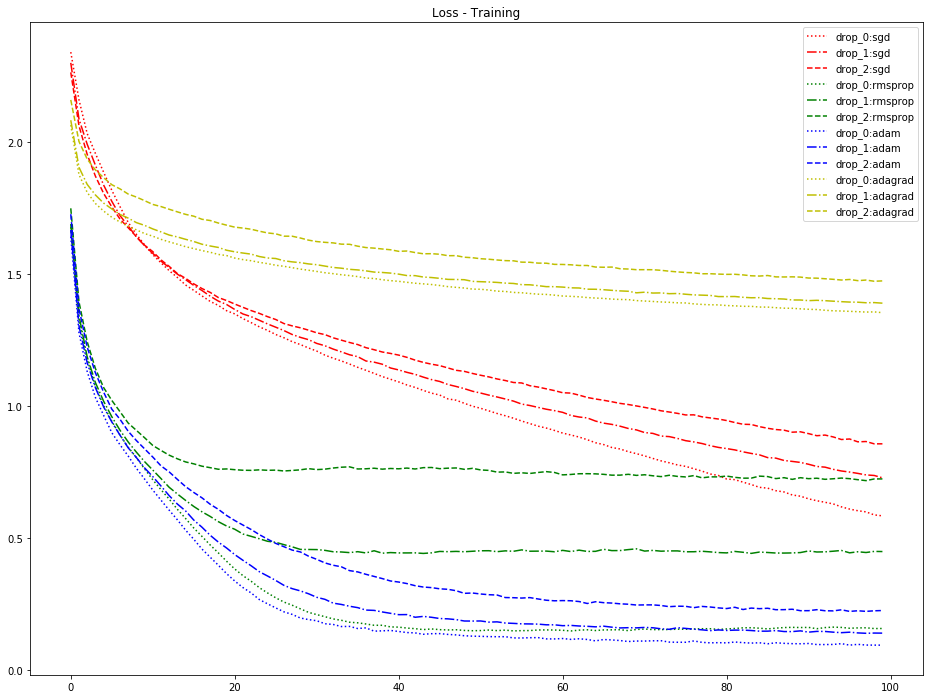

In [8]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(tra_loss["drop_0:sgd"][0])), tra_loss["drop_0:sgd"][0], ':' , label="drop_0:sgd", color="r")
plt.plot(range(len(tra_loss["drop_1:sgd"][0])), tra_loss["drop_1:sgd"][0], '-.', label="drop_1:sgd", color="r")
plt.plot(range(len(tra_loss["drop_2:sgd"][0])), tra_loss["drop_2:sgd"][0], '--', label="drop_2:sgd", color="r")

plt.plot(range(len(tra_loss["drop_0:rmsprop"][0])), tra_loss["drop_0:rmsprop"][0], ':' , label="drop_0:rmsprop", color="g")
plt.plot(range(len(tra_loss["drop_1:rmsprop"][0])), tra_loss["drop_1:rmsprop"][0], '-.', label="drop_1:rmsprop", color="g")
plt.plot(range(len(tra_loss["drop_2:rmsprop"][0])), tra_loss["drop_2:rmsprop"][0], '--', label="drop_2:rmsprop", color="g")

plt.plot(range(len(tra_loss["drop_0:adam"][0])), tra_loss["drop_0:adam"][0], ':' , label="drop_0:adam", color="b")
plt.plot(range(len(tra_loss["drop_1:adam"][0])), tra_loss["drop_1:adam"][0], '-.', label="drop_1:adam", color="b")
plt.plot(range(len(tra_loss["drop_2:adam"][0])), tra_loss["drop_2:adam"][0], '--', label="drop_2:adam", color="b")

plt.plot(range(len(tra_loss["drop_0:adagrad"][0])), tra_loss["drop_0:adagrad"][0], ':' , label="drop_0:adagrad", color="y")
plt.plot(range(len(tra_loss["drop_1:adagrad"][0])), tra_loss["drop_1:adagrad"][0], '-.', label="drop_1:adagrad", color="y")
plt.plot(range(len(tra_loss["drop_2:adagrad"][0])), tra_loss["drop_2:adagrad"][0], '--', label="drop_2:adagrad", color="y")

plt.title("Loss - Training")
plt.legend(loc="upper right")
plt.show()

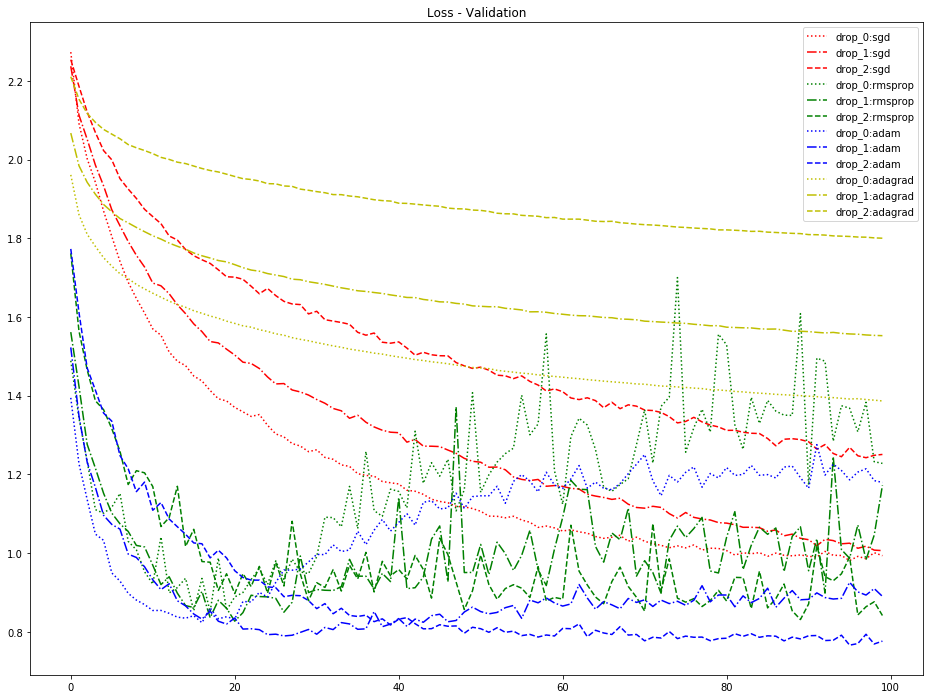

In [9]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(val_loss["drop_0:sgd"][0])), val_loss["drop_0:sgd"][0], ':' , label="drop_0:sgd", color="r")
plt.plot(range(len(val_loss["drop_1:sgd"][0])), val_loss["drop_1:sgd"][0], '-.', label="drop_1:sgd", color="r")
plt.plot(range(len(val_loss["drop_2:sgd"][0])), val_loss["drop_2:sgd"][0], '--', label="drop_2:sgd", color="r")

plt.plot(range(len(val_loss["drop_0:rmsprop"][0])), val_loss["drop_0:rmsprop"][0], ':' , label="drop_0:rmsprop", color="g")
plt.plot(range(len(val_loss["drop_1:rmsprop"][0])), val_loss["drop_1:rmsprop"][0], '-.', label="drop_1:rmsprop", color="g")
plt.plot(range(len(val_loss["drop_2:rmsprop"][0])), val_loss["drop_2:rmsprop"][0], '--', label="drop_2:rmsprop", color="g")

plt.plot(range(len(val_loss["drop_0:adam"][0])), val_loss["drop_0:adam"][0], ':' , label="drop_0:adam", color="b")
plt.plot(range(len(val_loss["drop_1:adam"][0])), val_loss["drop_1:adam"][0], '-.', label="drop_1:adam", color="b")
plt.plot(range(len(val_loss["drop_2:adam"][0])), val_loss["drop_2:adam"][0], '--', label="drop_2:adam", color="b")

plt.plot(range(len(val_loss["drop_0:adagrad"][0])), val_loss["drop_0:adagrad"][0], ':' , label="drop_0:adagrad", color="y")
plt.plot(range(len(val_loss["drop_1:adagrad"][0])), val_loss["drop_1:adagrad"][0], '-.', label="drop_1:adagrad", color="y")
plt.plot(range(len(val_loss["drop_2:adagrad"][0])), val_loss["drop_2:adagrad"][0], '--', label="drop_2:adagrad", color="y")

plt.title("Loss - Validation")
plt.legend(loc="upper right")
plt.show()

### Optimizer=Adam, l2=1e-4, dropout=0.5 有較低的loss

## Plot accu history

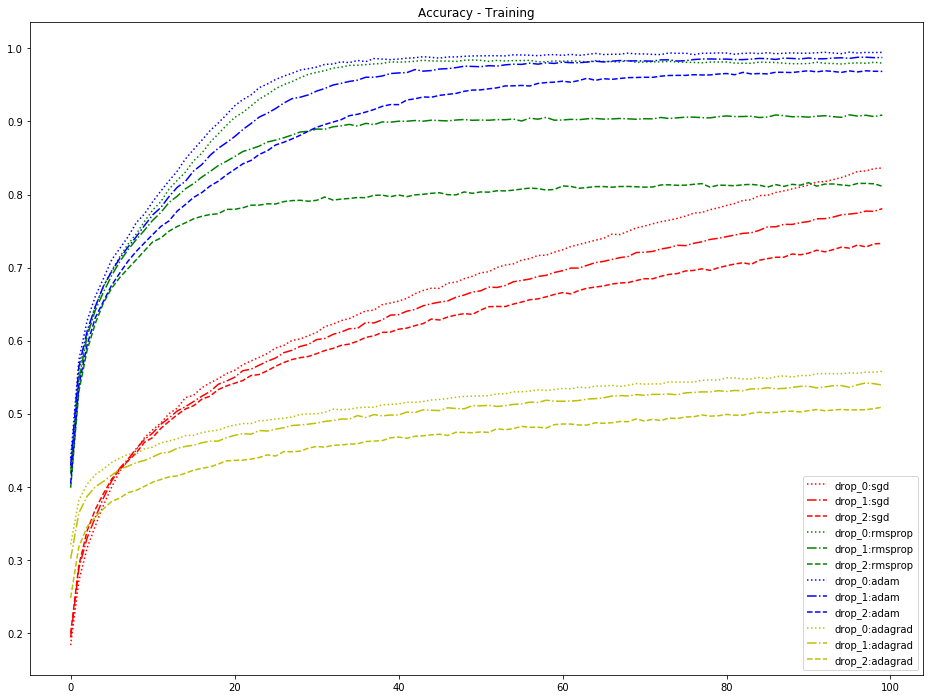

In [10]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(tra_accu["drop_0:sgd"][0])), tra_accu["drop_0:sgd"][0], ':' , label="drop_0:sgd", color="r")
plt.plot(range(len(tra_accu["drop_1:sgd"][0])), tra_accu["drop_1:sgd"][0], '-.', label="drop_1:sgd", color="r")
plt.plot(range(len(tra_accu["drop_2:sgd"][0])), tra_accu["drop_2:sgd"][0], '--', label="drop_2:sgd", color="r")

plt.plot(range(len(tra_accu["drop_0:rmsprop"][0])), tra_accu["drop_0:rmsprop"][0], ':' , label="drop_0:rmsprop", color="g")
plt.plot(range(len(tra_accu["drop_1:rmsprop"][0])), tra_accu["drop_1:rmsprop"][0], '-.', label="drop_1:rmsprop", color="g")
plt.plot(range(len(tra_accu["drop_2:rmsprop"][0])), tra_accu["drop_2:rmsprop"][0], '--', label="drop_2:rmsprop", color="g")

plt.plot(range(len(tra_accu["drop_0:adam"][0])), tra_accu["drop_0:adam"][0], ':' , label="drop_0:adam", color="b")
plt.plot(range(len(tra_accu["drop_1:adam"][0])), tra_accu["drop_1:adam"][0], '-.', label="drop_1:adam", color="b")
plt.plot(range(len(tra_accu["drop_2:adam"][0])), tra_accu["drop_2:adam"][0], '--', label="drop_2:adam", color="b")

plt.plot(range(len(tra_accu["drop_0:adagrad"][0])), tra_accu["drop_0:adagrad"][0], ':' , label="drop_0:adagrad", color="y")
plt.plot(range(len(tra_accu["drop_1:adagrad"][0])), tra_accu["drop_1:adagrad"][0], '-.', label="drop_1:adagrad", color="y")
plt.plot(range(len(tra_accu["drop_2:adagrad"][0])), tra_accu["drop_2:adagrad"][0], '--', label="drop_2:adagrad", color="y")

plt.title("Accuracy - Training")
plt.legend(loc="lower right")
plt.show()

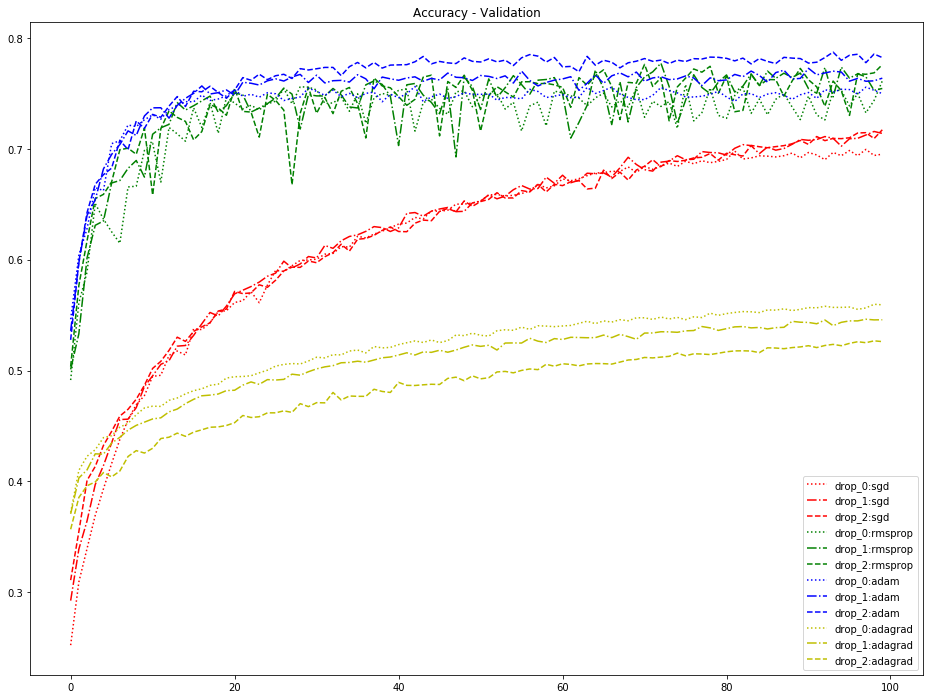

In [11]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(val_accu["drop_0:sgd"][0])), val_accu["drop_0:sgd"][0], ':' , label="drop_0:sgd", color="r")
plt.plot(range(len(val_accu["drop_1:sgd"][0])), val_accu["drop_1:sgd"][0], '-.', label="drop_1:sgd", color="r")
plt.plot(range(len(val_accu["drop_2:sgd"][0])), val_accu["drop_2:sgd"][0], '--', label="drop_2:sgd", color="r")

plt.plot(range(len(val_accu["drop_0:rmsprop"][0])), val_accu["drop_0:rmsprop"][0], ':' , label="drop_0:rmsprop", color="g")
plt.plot(range(len(val_accu["drop_1:rmsprop"][0])), val_accu["drop_1:rmsprop"][0], '-.', label="drop_1:rmsprop", color="g")
plt.plot(range(len(val_accu["drop_2:rmsprop"][0])), val_accu["drop_2:rmsprop"][0], '--', label="drop_2:rmsprop", color="g")

plt.plot(range(len(val_accu["drop_0:adam"][0])), val_accu["drop_0:adam"][0], ':' , label="drop_0:adam", color="b")
plt.plot(range(len(val_accu["drop_1:adam"][0])), val_accu["drop_1:adam"][0], '-.', label="drop_1:adam", color="b")
plt.plot(range(len(val_accu["drop_2:adam"][0])), val_accu["drop_2:adam"][0], '--', label="drop_2:adam", color="b")

plt.plot(range(len(val_accu["drop_0:adagrad"][0])), val_accu["drop_0:adagrad"][0], ':' , label="drop_0:adagrad", color="y")
plt.plot(range(len(val_accu["drop_1:adagrad"][0])), val_accu["drop_1:adagrad"][0], '-.', label="drop_1:adagrad", color="y")
plt.plot(range(len(val_accu["drop_2:adagrad"][0])), val_accu["drop_2:adagrad"][0], '--', label="drop_2:adagrad", color="y")

plt.title("Accuracy - Validation")
plt.legend(loc="lower right")
plt.show()

### Optimizer=Adam, lr=1e-4, Droupout=0.5有較好的準確率

In [12]:
## '-' solid line style
## '--' dashed line style
## '-.' dash-dot line style
## ':' dotted line style
## '.' point marker
## ',' pixel marker
## 'o' circle marker
## 'v' triangle_down marker
## '^' triangle_up marker
## '<' triangle_left marker
## '>' triangle_right marker
## '1' tri_down marker
## '2' tri_up marker
## '3' tri_left marker
## '4' tri_right marker
## 's' square marker
## 'p' pentagon marker
## '*' star marker
## 'h' hexagon1 marker
## 'H' hexagon2 marker
## '+' plus marker
## 'x' x marker
## 'D' diamond marker
## 'd' thin_diamond marker
## '|' vline marker
## '_' hline marker
## 
## 'b' blue
## 'g' green
## 'r' red
## 'c' cyan
## 'm' magenta
## 'y' yellow
## 'k' black
## 'w' white